In [1]:
import sys
sys.path.append('/home/jam1042/anaconda3/envs/skl_pys/lib/python3.9/site-packages/')
import numpy as np
from qmlearn.model import QMModel
from qmlearn.drivers.mol import QMMol
from qmlearn.api.api4ase import QMLCalculator
from qmlearn.io.model import db2qmmodel #Read data base and generate the model


from ase.build import molecule
from ase.optimize import LBFGS
from ase import Atoms

# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from qmlearn.io.hdf5 import DBHDF5

# from sklearn.linear_model import RidgeCV


#### Open DB

In [2]:
dbfile = '../H2_QML_sett.hdf5'     # <p^+ q r^+ s>
# dbfile = '../H2_QML_set_f.hdf5'  # Normal RDM <p^+ r^+ s q>
db = DBHDF5(dbfile)
refqmmol = db.read_qmmol(db.get_names('fci/qmmol')[0])
train_atoms = db.read_images(db.get_names('fci/train_atoms*')[0])
data_test = db.read_properties(db.get_names('fci/test_props_*')[0])
data_train = db.read_properties(db.get_names('fci/train_props_*')[0])

In [3]:
# data_test

In [4]:
db.names
# db.get_names('*/train*')
# db.get_names('*/qmmol')

['fci',
 'fci/qmmol',
 'fci/test_atoms_18',
 'fci/test_props_18',
 'fci/train_atoms_162',
 'fci/train_props_162',
 'hf',
 'hf/qmmol',
 'hf/test_atoms_18',
 'hf/test_props_18',
 'hf/train_atoms_162',
 'hf/train_props_162']

In [5]:
train_atoms_hf= db.read_images(db.get_names('hf/train_atoms*')[0])
data_test_hf = db.read_properties(db.get_names('hf/test_props_*')[0])
data_train_hf = db.read_properties(db.get_names('hf/train_props_*')[0])

In [6]:
db.close()

##### Pre processing Data

In [7]:
def rav_mat(data=None):
    '''Function to ravel (Flattening) Axis=1 of Vext and Gamma2'''
    m=np.zeros([np.shape(data)[0],np.shape(data[0].ravel())[0]])
    for i in np.arange(0,np.shape(data)[0]):
        m[i]=data[i].ravel()
    return m

In [8]:
# n_s=len(data_train['gamma2'])

In [9]:
# b_s=len(data_train['gamma2'][1])

In [10]:
# a=np.reshape(data_train['gamma2'],(n_s,(b_s**4)))

In [11]:
# np.shape(a)

In [12]:
# v=np.reshape(a,(n_s,b_s,b_s,b_s,b_s))

In [13]:
# data_train['gamma2']==v

In [14]:
# data_train['gamma2']==y

In [15]:
# y=np.reshape(y_tr,(n_s,b_s,b_s,b_s,b_s))

In [16]:
X_tr=rav_mat(data=data_train['vext'])
y_tr=rav_mat(data=data_train['gamma2'])

In [17]:
data_train['gamma2'][0]

array([[[[ 1.99427428e+00, -5.07511579e-12,  9.76674085e-03,
           3.58548284e-13],
         [-5.07511579e-12,  1.29156750e-23, -2.48548262e-14,
          -9.12492298e-25],
         [ 9.76674085e-03, -2.48548262e-14,  4.78315483e-05,
           1.75595112e-15],
         [ 3.58548284e-13, -9.12492298e-25,  1.75595112e-15,
           6.44691637e-26]],

        [[-5.07511579e-12, -2.38526173e-02,  5.13193708e-13,
          -2.30311589e-02],
         [ 0.00000000e+00,  6.07011762e-14, -8.67362391e-19,
           5.86106931e-14],
         [-2.48548262e-14, -1.16815592e-04,  2.51331023e-15,
          -1.12792589e-04],
         [-4.56203092e-25, -4.28843469e-15,  9.22518104e-26,
          -4.14074561e-15]],

        [[ 9.76674085e-03,  5.13193708e-13, -8.64873534e-02,
           3.42869326e-14],
         [-2.48548262e-14, -1.30610004e-24,  2.20096772e-13,
          -8.72316575e-26],
         [ 4.78315483e-05,  2.51331023e-15, -4.23562382e-04,
           1.67916514e-16],
         [ 1.7559

In [18]:
X_tr_hf=rav_mat(data=data_train_hf['vext'])

In [19]:
X_te=rav_mat(data=data_test['vext'])
y_te=rav_mat(data=data_test['gamma2'])

In [20]:
X_te_hf=rav_mat(data=data_test_hf['vext'])

In [21]:
X=np.concatenate([X_tr,X_te])
Y=np.concatenate([y_tr,y_te])

##### Define model/models and fit it/them

In [22]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV  #CrossValidation MRR
from sklearn.linear_model import Ridge

mmodels={
    'k_r': KernelRidge(alpha=0.1,kernel='linear'),
    'r_cv': RidgeCV(alphas=[1e-5,1e-4,1e-3, 1e-2, 1e-1,1e-1,1.5e-1]),
    'l_r': Ridge(alpha=0.15),
}

In [23]:
model = QMModel(mmodels=mmodels, refqmmol = refqmmol) #Build the model

In [24]:
met='k_r'

In [25]:
model.fit(X_tr,y_tr, method = met); #Train the model

#### Calculate Energy with predict 2-RDM

In [26]:
p_e=[]
e_e=[]
gamma_p=[]
for i in np.arange(0,len(data_train['gamma2'])):
    itest=i
    qmmol=model.refqmmol.duplicate(train_atoms[itest])
    gamma = model.predict(qmmol.vext, method = met)
#     gamma = model.predict(X_tr[itest], method = met)
    
    gamma_p.append(gamma)
    shape = data_train['gamma2'][0].shape
    gamma = gamma.reshape(shape)
    predicted_energy=qmmol.calc_etotal2(gamma,gamma1=data_train['gamma'][itest])
    p_e.append(predicted_energy)
    exact_energy=data_train['energy'][itest]
    e_e.append(exact_energy)
    print(predicted_energy-exact_energy)

0.007597638142167185
0.007113517333941388
0.006568319348810192
0.0042826264289241855
0.002956633756104221
0.003982898906920607
0.0018434358051795385
0.0022491674120797
0.0008846166511813358
0.0017950631041654397
0.00014983140360813607
-0.00012310757039379894
0.0008826894261182439
-0.0004741467487483497
0.0008137874278113522
0.001594073034919763
0.0016100035369084331
5.3359547944609176e-05
0.0018155954916401207
0.00016897580470853768
0.0021543036857574194
0.00047011878733549395
0.0030517691733011887
0.001272653946510438
0.004132416236757752
0.004091822404355128
0.0018616397381259198
0.0022201803579133816
0.0037027389363148977
0.006171244945456955
0.004811156391072657
0.003793585031859781
0.005947730863269385
0.004612120369199779
0.007081617465194867
0.007638683370391863
0.005805206421892972
0.01001082213640947
0.012944045786742908
0.018545997754239263
0.010611762116385481
0.019724473501810724
0.014292256679249826
0.011129293075927915
0.0214384676549213
0.0114151928454862
0.0154024464886

##### Plot the total Energy

In [27]:
npoints_1=50
R1_begin=0.05
R1_end=0.7
R1=np.linspace(start=R1_begin,stop=R1_end,num=npoints_1)

npoints_2 = 130
R2_begin=0.7
R2_end=4.5
R2 = np.linspace(start=R2_begin,stop=R2_end,num=npoints_2)

R=np.concatenate([R1,R2])

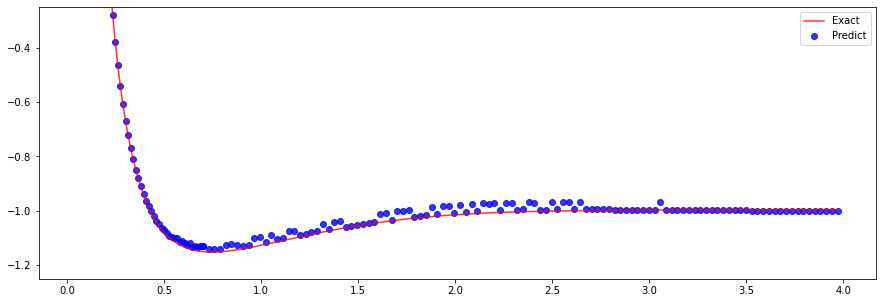

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(R[0:162],p_e,linestyle='-',alpha=0.8,label='Predict', color='blue')
ax.plot(R[0:162],e_e,linestyle='-',alpha=0.8,label='Exact', color='red')

ax.set_ylim([-1.25,-0.25])
plt.legend()

##### Function to get some metrics

In [29]:
def metric_error(gamma=None,true_gamma=None):
    r2=[]
    mae=[]
    rmse=[]
    
    '''Input:
    gamma: Predict gamma
    true_gamma: Exact(True) gamma'''
    
    if true_gamma is None:
        raise ValueError('Exact gamma need to be specified')
    
    for i in np.arange(0,len(gamma)):
        mae.append(mean_absolute_error(true_gamma[i],gamma[i]))
        r2.append(r2_score(true_gamma[i],gamma[i]))
        rmse.append(mean_squared_error(true_gamma[i],gamma[i],squared=False))
        #If True(Default) returns MSE value, if False returns RMSE value.
        print(r2[-1],mae[-1],rmse[-1])
    print('Average R2: ',np.average(r2), '\n',
         'Average MAE: ',np.average(mae), '\n',
         'Average RMSE: ',np.average(rmse), '\n',)
    
    print('R2: ',r2_score(true_gamma,gamma),'MAE: ',mean_absolute_error(true_gamma,gamma),
          'RMSE: ',mean_squared_error(true_gamma,gamma,squared=False))

In [30]:
metric_error(gamma=gamma_p,true_gamma=y_tr)

0.999360877403733 0.0007107028056524229 0.003155929694755016
0.9993760107253247 0.0006982491172072611 0.003118365679612273
0.9993903104740246 0.0006930420642412779 0.0030824549466644453
0.9984714176974837 0.0010183555547173216 0.004879313204209933
0.9994086707255244 0.0006811016954342125 0.003035753720359931
0.9985077655843384 0.0009820807352370422 0.004821004841768159
0.9994024837601578 0.0006680298952166601 0.003051673119088826
0.9985277824938034 0.0009457253641895016 0.0047886202999449096
0.9993624440332142 0.0006652889132996542 0.003152354117648767
0.9985273510337409 0.0009165167279432007 0.004789385529626229
0.9992831207747567 0.0006849928803994229 0.003342816278785315
0.9992277819954689 0.0007017102663180913 0.0034694974822970645
0.9984867444223571 0.0009133014295825582 0.004855068415713324
0.9990847627302716 0.0007324356376046077 0.003777270150414283
0.9984342882873236 0.000907660082069102 0.004938570075358844
0.9988979562978079 0.0007738600088309504 0.004145009369148377
0.99878

#### Get Energies from 2-RDM_HF from V_HF

##### Define model/models and fit it/them

In [31]:
# model.fit(X_tr,y_tr, method='gammat'); #Train the model
model.fit(X_tr_hf,y_tr, method = met); #Train the model

#### Calculate Energy with predict 2-RDM

In [32]:
p_e_hf=[]

gamma_p_hf=[]
for i in np.arange(0,len(data_train_hf['gamma'])):
    itest=i
    qmmol=model.refqmmol.duplicate(train_atoms_hf[itest])
    gamma = model.predict(qmmol.vext, method = met)
#     gamma = model.predict(X_tr_hf[itest], method = met)
    gamma_p_hf.append(gamma)
    
    shape = data_train['gamma2'][0].shape
    gamma = gamma.reshape(shape)
    
    predicted_energy=qmmol.calc_etotal2(gamma,gamma1=data_train['gamma'][itest])
    p_e_hf.append(predicted_energy)
    
    exact_energy=data_train['energy'][itest]  #EXACT CI energy
    
    print(predicted_energy-exact_energy)

0.005108788852845159
0.007113517334787822
0.004102680648767176
0.004282626428901537
0.002956633756098448
0.003206754814495394
0.0018434358051786504
0.0022491674120712624
0.0008846166511817799
0.001795063104162331
0.00014983140361435332
0.0021518838452410094
0.0008826894261160234
-0.00047414674874657337
0.00027202329324493846
-0.0005692810357600386
-0.0005246275388519628
0.0012100594131454478
0.0018155954916401207
0.0001689758047080936
0.0002978989348800809
0.00047011878733504986
0.0006824109233778408
0.0032297012564526106
0.004132416236757752
0.0021651516797289716
0.0018616397381259198
0.006031269028794473
0.0056161815955175776
0.004251408079103403
0.006743683763977604
0.008914271535329199
0.00792659230940318
0.010435041164299719
0.007081617465195311
0.007638683370390975
0.0127332583532076
0.0173541131930266
0.015225187593667311
0.010419169074991075
0.019137787229671854
0.010794993483680848
0.01429225667925027
0.011129293075927027
0.011278646668387182
0.011415192845485755
0.01540244648

##### Plot the total Energy

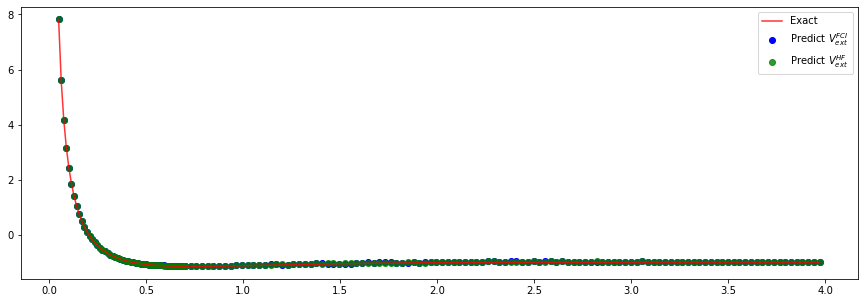

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))

ax.scatter(R[0:162],p_e,linestyle='-',alpha=1,label='Predict $V_{ext}^{FCI}$ ', color='blue')
ax.plot(R[0:162],e_e,linestyle='-',alpha=0.8,label='Exact', color='red')


ax.scatter(R[0:162],p_e_hf,linestyle='-',alpha=0.8,label='Predict $V_{ext}^{HF}$', color='green')


# ax.set_ylim([-1.25,-0.25])
plt.legend()

In [34]:
metric_error(gamma=gamma_p_hf,true_gamma=y_tr)

0.999360877403733 0.0007107028056524229 0.003155929694755016
0.9993760107253247 0.0006982491172072611 0.003118365679612273
0.9993903104740246 0.0006930420642412779 0.0030824549466644453
0.9984714176974837 0.0010183555547173216 0.004879313204209933
0.9994086707255244 0.0006811016954342125 0.003035753720359931
0.9985077655843384 0.0009820807352370422 0.004821004841768159
0.9994024837601578 0.0006680298952166601 0.003051673119088826
0.9985277824938034 0.0009457253641895016 0.0047886202999449096
0.9993624440332142 0.0006652889132996542 0.003152354117648767
0.9985273510337409 0.0009165167279432007 0.004789385529626229
0.9992831207747567 0.0006849928803994229 0.003342816278785315
0.9992277819954689 0.0007017102663180913 0.0034694974822970645
0.9984867444223571 0.0009133014295825582 0.004855068415713324
0.9990847627302716 0.0007324356376046077 0.003777270150414283
0.9984342882873236 0.000907660082069102 0.004938570075358844
0.9988979562978079 0.0007738600088309504 0.004145009369148377
0.99878

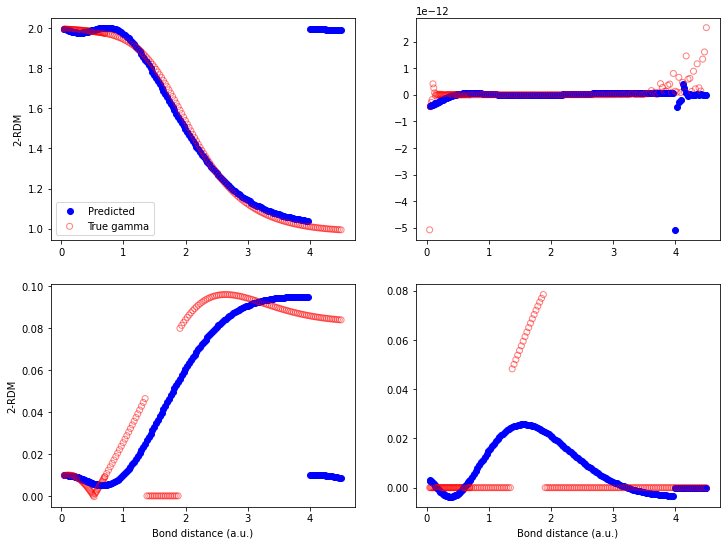

In [35]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,2,figsize=(12, 9))

predic_g_trr=np.concatenate([gamma_p,y_tr])

gamma_p


element=0
element2=1
ax[0,0].scatter(R[0],predic_g_trr[0][element:element2], color='blue',label='Predicted') 
ax[0,0].scatter(R[0],Y[0][element:element2], color='red',label='True gamma',alpha=0.5, facecolors='none')
ax[0,0].legend()
for i in np.arange(0,len(R)):
    ax[0,0].scatter(R[i],predic_g_trr[i][element:element2], color='blue',label='Predicted') 
    ax[0,0].scatter(R[i],Y[i][element:element2], color='red',label='True gamma',alpha=0.5, facecolors='none')
    
element=1
element2=2
for i in np.arange(0,len(R)):
    ax[0,1].scatter(R[i],predic_g_trr[i][element:element2], color='blue',label='Predicted') 
    ax[0,1].scatter(R[i],Y[i][element:element2], color='red',label='True gamma',alpha=0.5, facecolors='none')

element=2
element2=3
for i in np.arange(0,len(R)):
    ax[1,0].scatter(R[i],predic_g_trr[i][element:element2], color='blue',label='Predicted') 
    ax[1,0].scatter(R[i],Y[i][element:element2], color='red',label='True gamma',alpha=0.5, facecolors='none')
    
element=3
element2=4
for i in np.arange(0,len(R)):
    ax[1,1].scatter(R[i],predic_g_trr[i][element:element2], color='blue',label='Predicted') 
    ax[1,1].scatter(R[i],Y[i][element:element2], color='red',label='True gamma',alpha=0.5, facecolors='none')

ax[1,0].set_ylabel('2-RDM')
ax[0,0].set_ylabel('2-RDM')
ax[1,0].set_xlabel('Bond distance (a.u.)')
ax[1,1].set_xlabel('Bond distance (a.u.)')

# plt.savefig('Ridg_Reg_bd_2rdm_C.pdf')

plt.show()